# TMA01 Question 1 (35 marks)

Name: Diran Suraj

PI: Z7279378

In this question you will attempt to distinguish between traffic between data sent over a VPN link and traffic that isn't. In Question 2, you will classify the traffic into different types.

This question uses datasets of preprocessed flows. Each flow is labelled with whether that flow went over a VPN or not.

## Completing the question
The tasks in this notebook can be addressed using the techniques discussed in the Foundation and Block 1 of the module materials, and the associated notebooks.

> **You should be able to complete this question when you have completed the practical activities in Block 1**
>
> You should look at the notebooks for Block 1 while working through this question. You will find many useful examples in those notebooks which will help you in this assignment.

Record all your activity and observations in this notebook. Insert additional notebook cells as required. Remember to run each cell in sequence and to rerun cells if you make any changes in earlier cells. 

Include Markdown cells (like this one) liberally in your solutions, to describe what you are doing. This will help your tutor give full credit for all you have done, and is invaluable in reminding you what you were doing when you return to the TMA after a few days away.

Before you submit your notebook make sure you run all cells in order and check that you get the results you expect. (It is not unknown to receive notebooks which don't work when the cells are run in order.)

See the VLE for details of how to submit your completed notebook. You should submit only this notebook file for this question.

## Marks are based on process, not results

In this notebook, you will be asked to create, train, and evaluate several neural networks. Training neural networks is inherently a stochastic process, based on the random allocation of initial weights and the shuffled order of training examples. Therefore, your results will differ from results generated by other students, and those generated by the module team and presented in the tutor's marking guide.

The marks in this question are awarded solely on your ability to carry out the steps of training and evaluation, not on any particular results you may achieve. **There are no thresholds for accuracy (or any other metric) you must achieve.** You will gain credit for carrying out the tasks specified in this question, including honest evaluations of how the models perform. 

## Setup

This imports the required libraries.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils

import os
import json
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We define some constants we will use later and define some metrics to use for model evaluation.

In [ ]:
BATCH_SIZE = 64

METRICS = [
      lambda : metrics.TruePositives(name='tp'),
      lambda : metrics.FalsePositives(name='fp'),
      lambda : metrics.TrueNegatives(name='tn'),
      lambda : metrics.FalseNegatives(name='fn'), 

      lambda : metrics.BinaryAccuracy(name='accuracy'),
      lambda : metrics.Precision(name='precision'),
      lambda : metrics.Recall(name='recall'),
      lambda : metrics.AUC(name='auc'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

Define a function for plotting ROC curves.

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, show_points=True, show_point_labels=True, **kwargs):
    """Plot the ROC curve for a binary classifer, given some labels and predictions for those labels.
    name is the name shown in the legend.
    if show_points is True, show the locations on the curve if the threshold is set to 0.25, 0.5, and 0.75."""
    
    # Calcuate the points of the curve
    fpr, tpr, ths = sklearn.metrics.roc_curve(labels, predictions)

    # Plot as percentabes
    plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positive rate [%]')
    plt.ylabel('True positive rate [%]')
    text_x_offset = 3
    text_y_offset = 3
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
    # Show the locations of various thresholds.
    if show_points:
        for pt in [0.25, 0.5, 0.75]:  
            pi = np.argmax(ths < pt)
            px = fpr[pi] * 100
            py = tpr[pi] * 100
            plt.plot(px, py, marker="o", markersize=10, **kwargs)
            if show_point_labels:
                ax.text(x = px + text_x_offset, y = py - text_y_offset, s = f'{pt}')
    
    return fpr, tpr, ths

## Loading and preparing the dataset

This section of the notebook loads the dataset and makes it available for training.

In [ ]:
class_names = {0: 'Not VPN', 1: 'VPN'}

Where to find the data.

In [ ]:
base_dir = '/datasets/cybersecurity/vpn-nonvpn/'

In [ ]:
train_data = tf.data.Dataset.load(os.path.join(base_dir, f'scenario_a1_15s_train'))
train_data = train_data.cache()
train_data = train_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(1000)
train_data

In [ ]:
validation_data = tf.data.Dataset.load(os.path.join(base_dir, f'scenario_a1_15s_validation'))
validation_data = validation_data.batch(BATCH_SIZE)
validation_data

In [ ]:
test_data = tf.data.Dataset.load(os.path.join(base_dir, f'scenario_a1_15s_test'))
test_data = test_data.batch(BATCH_SIZE)
test_data

In [ ]:
input_shape = (train_data.element_spec[0].shape[1],)
input_shape

## Jittered labels

The labels of the validation set, jittered. These may be useful for charts similar to those in the Foundations notebooks.

In [ ]:
validation_labels = np.array(list(validation_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_labels.shape

In [ ]:
jittered_validation_labels = validation_labels + (np.random.random(validation_labels.shape) * 0.8)
jittered_validation_labels.shape

In [ ]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels.shape

In [ ]:
jittered_labels = test_labels + (np.random.random(test_labels.shape) * 0.8)
jittered_labels.shape

# Define and train a sample model

We now create and train a simple model using these datasets.

You should use this example as a basis for the models of your own that you create in this question.

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(8, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Note that we're using **binary** cross entropy as the loss function (as there are two classes). Categorical cross-entropy is used when there are multiple classes, one-hot encoded.

In [39]:
opt = optimizers.RMSprop()
model.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
history = model.fit(train_data,
    validation_data=validation_data,
    epochs=5,
    verbose=0)

Save and reload the model and the training history.

In [41]:
model.save('q1_sample.keras')

with open('q1_sample_history.json', 'w') as f:
    json.dump(history.history, f)

In [42]:
model = tf.keras.models.load_model('q1_sample.keras')

with open('q1_sample_history.json') as f:
    sample_history = json.load(f)

Plot the training history.

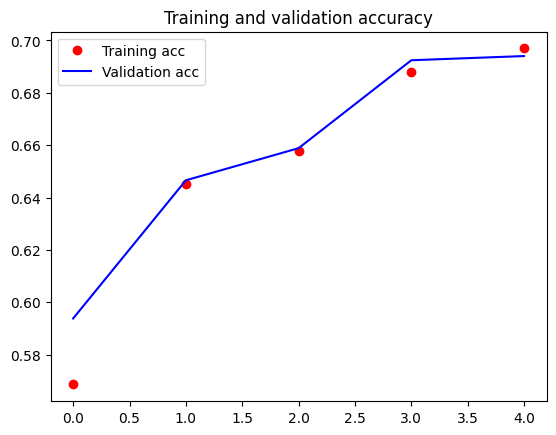

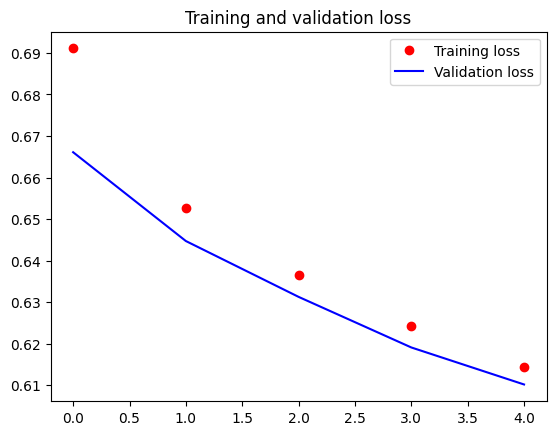

In [43]:
acc = sample_history['accuracy']
val_acc = sample_history['val_accuracy']
loss = sample_history['loss']
val_loss = sample_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Update the metrics used on the model and evaluate them on the validation data.

In [44]:
model.compile(metrics=fresh_metrics(), loss='binary_crossentropy')
model.evaluate(validation_data, return_dict=True)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6977 - auc: 0.7398 - fn: 132.6774 - fp: 176.0323 - loss: 0.6111 - precision: 0.6925 - recall: 0.7364 - tn: 314.1613 - tp: 396.2258


{'accuracy': 0.6940298676490784,
 'auc': 0.7353957891464233,
 'fn': 237.0,
 'fp': 337.0,
 'loss': 0.6101354360580444,
 'precision': 0.6856343150138855,
 'recall': 0.7561728358268738,
 'tn': 567.0,
 'tp': 735.0}

**You are now able to work on the tasks in this TMA question.**

# (a) (4 marks): examine the model

Referring to the sample model above:
* show how many trainable parameters it has
* extract the shape of the input to the model

In [45]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 8)              │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201 (804.00 B)

 Trainable params: 201 (804.00 B)

 Non-trainable params: 0 (0.00 B)

201 trainable parameters

In [46]:
input_shape

(23,)

# (b) (6 marks): new model, train it

Following the sample model defined above, create and train a new classifier model of this dataset. Your new model should have an `Input` layer and four `Dense` layers.

The `Dense` layers should have these parameters:
* 64 units, `relu` activation
* 64 units, `relu` activation
* 32 units, `relu` activation
* 1 unit, `sigmoid` activation

Training should use the `RMSprop` optimiser with the default learning rate.

Remember to use `binary_crossentropy` as the loss function

Train your modified model for **300** epochs. Use `verbose=0`. Show plots of how the accuracy and loss changed over training, for both the training and validation datasets.

(You may wish to save your model and the training history.)

In [47]:
model_b = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [48]:
opt = optimizers.RMSprop()
model_b.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [72]:
history = model_b.fit(train_data,
    validation_data=validation_data,
    epochs=300,
    verbose=0)

In [73]:
model_b.save('q1b_sample.keras')

with open('q1b_sample_history.json', 'w') as f:
    json.dump(history.history, f)

In [74]:
model_b = tf.keras.models.load_model('q1b_sample.keras')

with open('q1b_sample_history.json') as f:
    history_b = json.load(f)

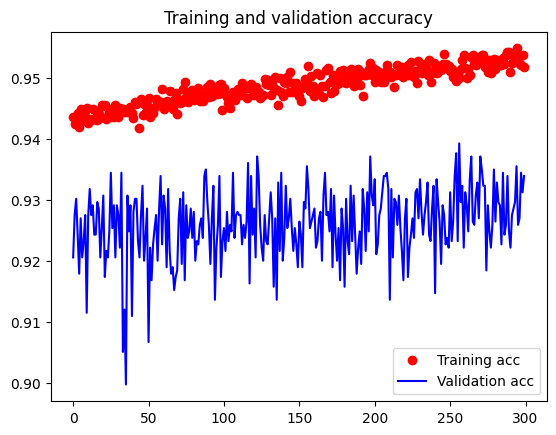

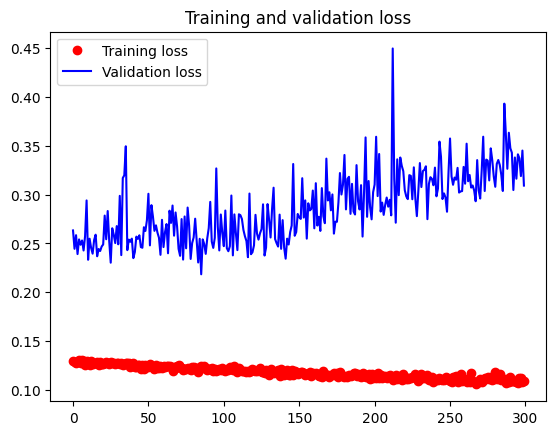

In [75]:
acc = history_b['accuracy']
val_acc = history_b['val_accuracy']
loss = history_b['loss']
val_loss = history_b['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# (c) (5 marks): comment on training

Comment on the plots of loss and accuracy, for both training and validation data, during the training of this model. Do you think this model would benefit from additional training?

The performance on the training data is higher than the validation data.

Both the training accuracy and the validation accuracy increase linearly, however the training accuracy appears to increase  faster and in a less sporadic way - the training accuracy is mostly flat. The validation loss is increasing, especially after 150 epochs and the training loss decreases incrementally. This suggests, the model began overfitting after 150 epochs.

The difference between the training and validation performance suggests that the further training will not be effective.

# (d) (10 marks): evaluate with new metrics

Recompile the model from part (b) above to use the metrics defined by the `fresh_metrics` function defined above. 

Evaluate the model, using these metrics, on all three of the **train**, **validation**, and **test** datasets. 

Use that model to generate predicted classes for all elements in the **test** dataset. Plot a scatter chart of the predicted results with the actual results (defined above as either `test_labels` or `jittered_labels`.)

Generate and plot the ROC curve for this, using the **test** dataset.

Comment on these results. 

In [53]:
model_b.compile(metrics=fresh_metrics(), loss='binary_crossentropy')
model_b.evaluate(train_data, return_dict=True)

206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9472 - auc: 0.9901 - fn: 83.8261 - fp: 267.1449 - loss: 0.1246 - precision: 0.9269 - recall: 0.9761 - tn: 2918.1980 - tp: 3354.8696


{'accuracy': 0.9469996690750122,
 'auc': 0.9910845160484314,
 'fn': 159.0,
 'fp': 537.0,
 'loss': 0.12037170678377151,
 'precision': 0.9251672029495239,
 'recall': 0.9766107797622681,
 'tn': 5797.0,
 'tp': 6639.0}

In [54]:
model_b.evaluate(validation_data, return_dict=True)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9164 - auc: 0.9716 - fn: 20.9355 - fp: 60.7097 - loss: 0.2823 - precision: 0.8872 - recall: 0.9588 - tn: 429.4839 - tp: 507.9677


{'accuracy': 0.9259061813354492,
 'auc': 0.9757000803947449,
 'fn': 41.0,
 'fp': 98.0,
 'loss': 0.24809670448303223,
 'precision': 0.9047619104385376,
 'recall': 0.9578189253807068,
 'tn': 806.0,
 'tp': 931.0}

In [55]:
model_b.evaluate(test_data, return_dict=True)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9317 - auc: 0.9745 - fn: 32.6500 - fp: 105.4167 - loss: 0.2687 - precision: 0.9035 - recall: 0.9702 - tn: 836.2333 - tp: 975.7667


{'accuracy': 0.9250666499137878,
 'auc': 0.9745469093322754,
 'fn': 73.0,
 'fp': 208.0,
 'loss': 0.25980865955352783,
 'precision': 0.900335431098938,
 'recall': 0.962602436542511,
 'tn': 1590.0,
 'tp': 1879.0}

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


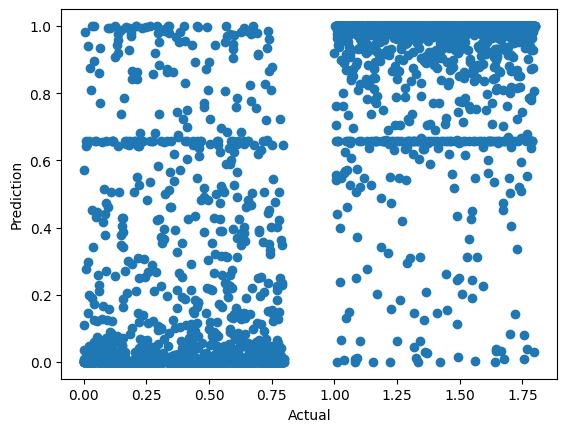

In [56]:
tps = model_b.predict(test_data)
model_predictions = tps[:, 0]
plt.scatter(jittered_labels, model_predictions)
plt.xlabel('Actual')
plt.ylabel('Prediction');

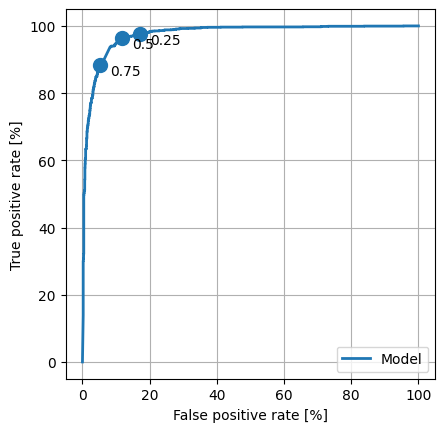

In [57]:
plot_roc("Model", test_labels, model_predictions, color=colors[0])
plt.legend(loc='lower right')

For the scatter plot, most points are clustered near the top or bottom of their bands, suggesting that the model is confident of its classification. There are few points that are in the 'wrong' half of each band, which agrees with the model's evaluation of an 92% accuracy. There is also a strip of data points around 0.60.

When the threshold is set at 0.5, around 95% of the traffic was classified as VPN, and about 5% of the reported VPN link traffic was not.

For the ROC curve, if the threshold were set at 0.25, more traffic data would be reported as VPN. From the graph, over 95% of the VPN traffic would be classified as VPN, but about 20% of the reported VPN link traffic would not be from a VPN link. If the threshold were set at 0.75, fewer data would be reported as VPN traffic. Around 90% of the VPN traffic would be classified as VPN traffic, but less than 5% of the reported VPN traffic would be not be VPN traffic.

# (e) (10 marks): Experiments

Neural network models with the same structure can vary in different hyperparameters. In this part, you will train and evaluate two variations of the model you used in part (b) above, to see how these changes affect model training and performance.

1. The first variation should use a new model with the same definition as in part (b), but you should use the RMSprop optimiser with the default learning rate and train the model for 300 epochs. Store the model in a variable called `model_e1`.
2. The second variation should use a new model with the same definition as in part (b), but with `sigmoid` activation in all `Dense` layers, the  RMSprop optimiser with the default learning rate, and train the model for **600** epochs. Store the model in a variable called `model_e2`.

For each model:
* plot and comment on the metrics generated during training
* evaluate the model (with `fresh_metrics`) on the test dataset
* generate a scatter diagram of predictions
* comments on the evaluation and scatter diagram

Finally, generate an ROC curve with all three models: `model_b`, `model_e`, and `model_e2. Comment on these curves.

In [76]:
model_e1 = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [77]:
opt = optimizers.RMSprop()
model_e1.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [78]:
history_e1 = model_e1.fit(train_data,
    validation_data=validation_data,
    epochs=300,
    verbose=0)

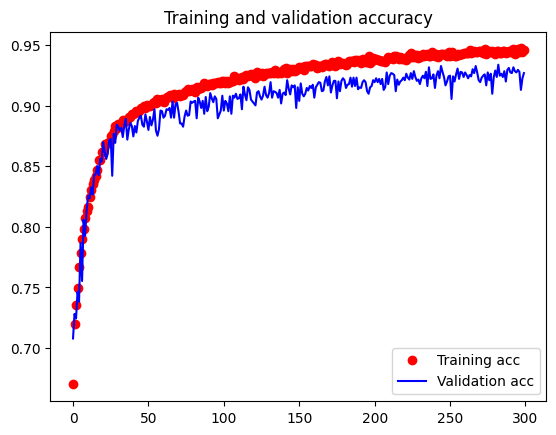

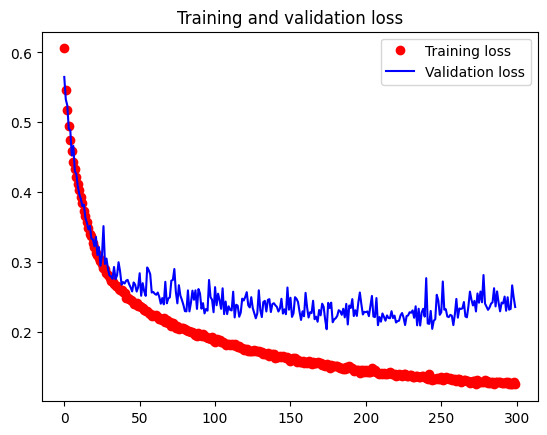

In [80]:
acc = history_e1.history['accuracy']
val_acc = history_e1.history['val_accuracy']
loss = history_e1.history['loss']
val_loss = history_e1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The performance on the training data is higher than the validation data.

At around 200 epochs, both the training accuracy and the validation accuracy became very flat (only increasing minutely), and the validation loss began to increase around 250 epochs, separating from the training loss. This suggests the model is overfitting to the data at around 250 epochs.

The difference between the training and validation performance suggests that the later stages of training are less effective than the earlier stages.

Therefore, this model will likely not benefit from additional training.

In [82]:
model_e1.compile(metrics=fresh_metrics(), loss='binary_crossentropy')
model_e1.evaluate(test_data, return_dict=True)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9238 - auc: 0.9742 - fn: 55.2333 - fp: 94.0333 - loss: 0.2513 - precision: 0.9106 - recall: 0.9434 - tn: 847.6166 - tp: 953.1833


{'accuracy': 0.9218666553497314,
 'auc': 0.9732652306556702,
 'fn': 113.0,
 'fp': 180.0,
 'loss': 0.2583625018596649,
 'precision': 0.9108469486236572,
 'recall': 0.9421106576919556,
 'tn': 1618.0,
 'tp': 1839.0}

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


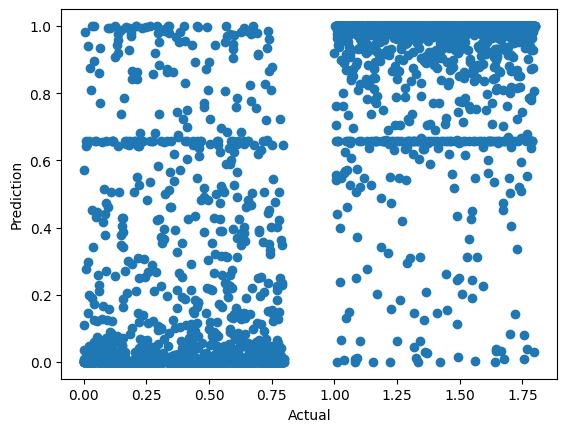

In [83]:
tps = model_e1.predict(test_data)
model_e1_predictions = tps[:, 0]
plt.scatter(jittered_labels, model_predictions)
plt.xlabel('Actual')
plt.ylabel('Prediction');

For the scatter plot, most points are clustered near the top or bottom of their bands, suggesting that the model is confident of its classification. There are few points that are in the 'wrong' half of each band, which agrees with the model's evaluation of an 92% accuracy. There is also a strip of data points around 0.65.

In [86]:
model_e2 = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'), 
    tf.keras.layers.Dense(64, activation='sigmoid'), 
    tf.keras.layers.Dense(32, activation='sigmoid'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [87]:
opt = optimizers.RMSprop()
model_e2.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [88]:
history_e2 = model_e2.fit(train_data,
    validation_data=validation_data,
    epochs=600,
    verbose=0)

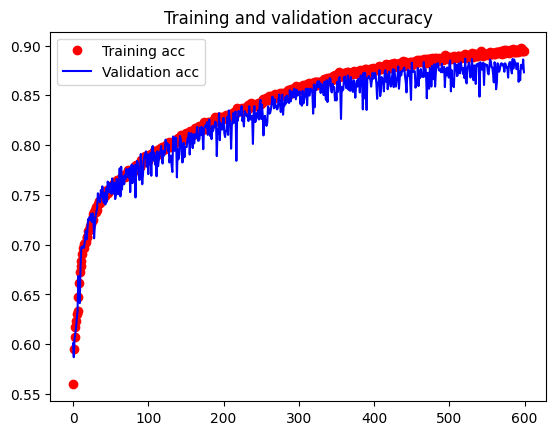

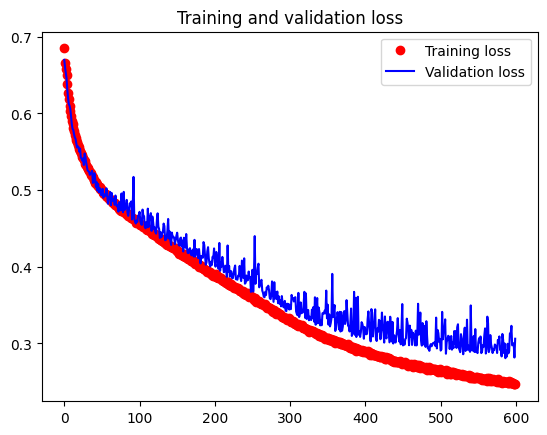

In [89]:
acc = history_e2.history['accuracy']
val_acc = history_e2.history['val_accuracy']
loss = history_e2.history['loss']
val_loss = history_e2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The performance on the training data is higher than the validation data, but only slighty.

After 50 epochs, both the training accuracy and the validation accuracy climb steadily, and only flatten around 500 epochs. The validation loss began to separate from the training loss around 400 epochs. This suggests the model is overfitting to the data at around 450 epochs.

The difference between the training and validation performance suggests that the later stages of training are less effective than the earlier stages.

Therefore, this model will likely not benefit from additional training.

In [90]:
model_e2.compile(metrics=fresh_metrics(), loss='binary_crossentropy')
model_e2.evaluate(test_data, return_dict=True)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8696 - auc: 0.9512 - fn: 149.0833 - fp: 108.3167 - loss: 0.3052 - precision: 0.8852 - recall: 0.8561 - tn: 833.3333 - tp: 859.3333


{'accuracy': 0.8645333051681519,
 'auc': 0.9498332738876343,
 'fn': 298.0,
 'fp': 210.0,
 'loss': 0.30699193477630615,
 'precision': 0.8873390555381775,
 'recall': 0.8473360538482666,
 'tn': 1588.0,
 'tp': 1654.0}

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


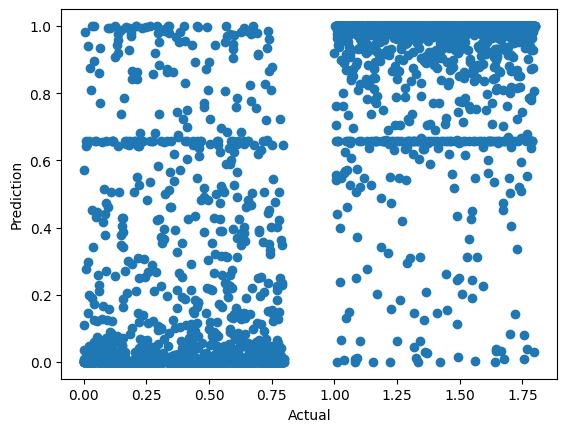

In [91]:
tps = model_e2.predict(test_data)
model_e2_predictions = tps[:, 0]
plt.scatter(jittered_labels, model_predictions)
plt.xlabel('Actual')
plt.ylabel('Prediction');

For the scatter plot, most points are clustered near the top or bottom of their bands, suggesting that the model is confident of its classification. There are few points that are in the 'wrong' half of each band, which agrees with the model's evaluation of an 86% accuracy. There is also a strip of data points around 0.65.

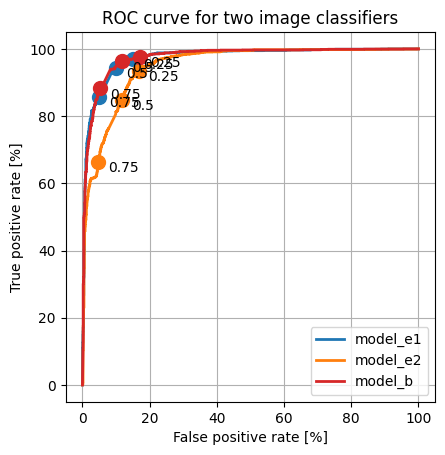

In [92]:
plot_roc("model_e1", test_labels, model_e1_predictions, show_points=True, color=colors[0])
plot_roc("model_e2", test_labels, model_e2_predictions, show_points=True, color=colors[1])
plot_roc("model_b", test_labels, model_predictions, show_points=True, color=colors[3])
plt.title('ROC curve for two image classifiers')
plt.legend(loc='lower right')

The ROC curves reinforce the lessons from the models' metrics and the scatter plots. Model e2 has poorer performance than e1 and b. Both e1 and b are the same model.

Model e2 has a broader spread of decision points which reinforces a lack of separation in predictions. A small change in decision threshold has a larger effect on the e2's performance. e2 has twice the epochs of e1, which suggests this poorer performance is due to the sigmoid activation function in its first 3 layers as opposed to ReLU.

The ROC curve reinforces that model e1 and b are likely to be the best models to use, should we wish to classify VPN and non-VPN traffic.